<a href="https://colab.research.google.com/github/MOOWOO/fastfood-classification/blob/main/cnn_fastfood_classification_skeleton_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up Environment & Prepare the Dataset

In [ ]:
# Set up Environment & Prepare the Dataset
!pip install torch torchvision torchaudio transformers

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from transformers import ConvNextForImageClassification, ConvNextImageProcessor
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import zipfile
from google.colab import drive
import cv2
%matplotlib inline

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


In [ ]:
# Define utility functions
def extract_zip(filename, input_path, output_base_path):
    output_path = os.path.join(output_base_path, filename)
    os.makedirs(output_path, exist_ok=True)
    with zipfile.ZipFile(input_path, 'r') as zip_file:
        zip_file.extractall(output_path)
    print(f"Extracted {filename}.zip to {output_path}.")

def get_classes_for_dataset(filename, base_path):
    data_path = os.path.join(base_path, filename)
    classes = sorted(os.listdir(data_path))
    classes_dict = {i: item for i, item in enumerate(classes)}
    classes_rev = {value: key for key, value in classes_dict.items()}
    return classes_dict, classes_rev

In [ ]:
# Dataset paths
source_path = '/content/drive/MyDrive/fastfood'
target_base_path = './data'
train_filename = "Train"
test_filename = "Test"

# Extract Train and Test datasets
extract_zip(train_filename, os.path.join(source_path, train_filename + ".zip"), target_base_path)
extract_zip(test_filename, os.path.join(source_path, test_filename + ".zip"), target_base_path)

# Load classes and map them
train_classes, train_classes_rev = get_classes_for_dataset(train_filename, target_base_path)


Extracted Train.zip to ./data/Train.
Extracted Test.zip to ./data/Test.


In [ ]:
# Preprocess the dataset
# def preprocess_data(data_dir, class_rev, image_size=(224, 224)):
#     data, labels = [], []
#     for class_name, class_idx in class_rev.items():
#         img_dir = os.path.join(data_dir, class_name)
#         for image_name in os.listdir(img_dir):
#             img = Image.open(os.path.join(img_dir, image_name)).convert("RGB").resize(image_size)
#             data.append(np.array(img).astype('float32') / 255)
#             labels.append(class_idx)
#     return np.array(data), np.array(labels)


In [ ]:
# 경계선 탐지 함수
def apply_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # PIL 이미지는 RGB로 가져오므로 적절히 변환
    edges = cv2.Canny(gray, 100, 200)
    return edges

# 데이터 전처리 함수 (경계선 탐지 포함)
def preprocess_data(data_dir, class_rev, image_size=(224, 224), apply_edge=False):
    data, labels = [], []

    for class_name, class_idx in class_rev.items():
        img_dir = os.path.join(data_dir, class_name)

        # 디렉터리 내의 각 이미지를 읽고 처리
        for image_name in os.listdir(img_dir):
            img_path = os.path.join(img_dir, image_name)

            # 이미지 열기, RGB로 변환 후 리사이즈
            img = Image.open(img_path).convert("RGB").resize(image_size)
            img_array = np.array(img).astype('float32') / 255  # 이미지를 NumPy 배열로 변환

            # apply_edge 플래그에 따라 경계선 탐지 적용
            if apply_edge:
                # 경계선 탐지를 적용하려면 OpenCV용 형식으로 변환한 뒤 적용
                img_array = apply_edge_detection(np.uint8(img_array * 255))  # 255 배율로 다시 이미지 복원
                img_array = img_array.astype('float32') / 255  # 다시 float32로 변환하여 스케일링

                # 경계선 이미지를 채널 추가로 확장 (Canny 결과는 단일 채널이므로 RGB로 맞추기 위해 3채널로 확장)
                img_array = np.stack([img_array] * 3, axis=-1)

            data.append(img_array)
            labels.append(class_idx)

    return np.array(data), np.array(labels)

In [ ]:
data, labels = preprocess_data(os.path.join(target_base_path, train_filename), train_classes_rev)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# **Plot class distribution**
def plot_class_distribution(labels, class_mapping):
    train_label_str = [key for label_int in labels.tolist() for key, value in class_mapping.items() if value == label_int]
    df_train_label = pd.DataFrame(train_label_str, columns=['label'])
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='label', data=df_train_label, order=list(class_mapping.keys()))
    ax.set_title('Train Label Distribution')
    plt.xticks(rotation=45, ha="right")
    plt.show()

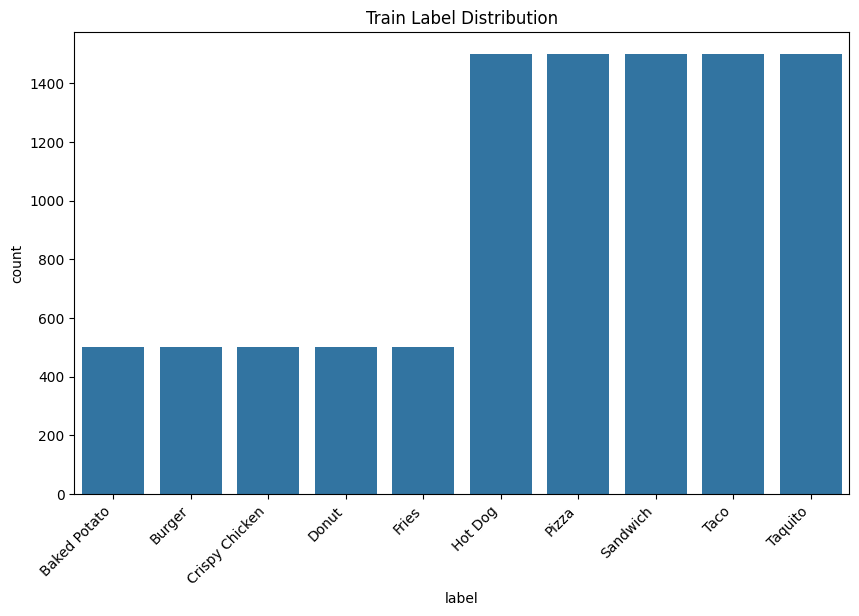

In [ ]:
# Call plot function to visualize label distribution
plot_class_distribution(labels, train_classes_rev)

In [ ]:
# Data augmentation using ImageDataGenerator
def augment_data(X_train, y_train):
    # Ensure the input data has the right dimensions (batch_size, height, width, channels)
    if X_train.ndim == 3:
        X_train = np.expand_dims(X_train, axis=-1)  # If the data is missing the channel dimension, add it

    generator = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.1,
    )

    # Fit the generator to the data
    generator.fit(X_train)

    # Augment the data (retain the 4D shape: batch, height, width, channels)
    aug1 = next(generator.flow(X_train, batch_size=len(X_train), shuffle=False))
    aug2 = next(generator.flow(X_train, batch_size=len(X_train), shuffle=False))

    # Concatenate the original and augmented data
    X_train_aug = np.concatenate((X_train, aug1, aug2))
    y_train_aug = np.concatenate((y_train, y_train, y_train))

    return X_train_aug, y_train_aug

In [ ]:
# 위에가 더 잘나옴
# def augment_data(X_train, y_train):
#     # Ensure the input data has the right dimensions (batch_size, height, width, channels)
#     if X_train.ndim == 3:
#         X_train = np.expand_dims(X_train, axis=-1)  # If the data is missing the channel dimension, add it

#     # 기본 데이터 증강기 (다른 클래스)
#     general_generator = ImageDataGenerator(
#         rotation_range=15,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip=True,
#         zoom_range=0.1,
#         shear_range=0.05,
#     )

#     # 7: 'Sandwich', 8: 'Taco', 9: 'Taquito'에 대한 더 강력한 증강기
#     special_generator = ImageDataGenerator(
#         rotation_range=30,       # 더 강한 회전
#         width_shift_range=0.3,   # 더 강한 수평 이동
#         height_shift_range=0.3,  # 더 강한 수직 이동
#         horizontal_flip=True,
#         zoom_range=0.3,          # 더 강한 줌
#         shear_range=0.2,         # 더 강한 기울이기
#     )

#     # 데이터 증강 결과를 저장할 리스트
#     X_train_aug, y_train_aug = [], []

#     # 각 샘플에 대해 해당하는 증강을 적용
#     for i in range(len(X_train)):
#         x = X_train[i]
#         y = y_train[i]

#         # 특정 클래스(7: 'Sandwich', 8: 'Taco', 9: 'Taquito')에 대해 강한 증강 적용
#         if y in [7, 8, 9]:
#             # 특별한 증강기 사용
#             aug1 = next(special_generator.flow(np.expand_dims(x, axis=0), batch_size=1, shuffle=False))
#             aug2 = next(special_generator.flow(np.expand_dims(x, axis=0), batch_size=1, shuffle=False))
#         else:
#             # 일반 증강기 사용
#             aug1 = next(general_generator.flow(np.expand_dims(x, axis=0), batch_size=1, shuffle=False))
#             aug2 = next(general_generator.flow(np.expand_dims(x, axis=0), batch_size=1, shuffle=False))

#         # 원본 및 증강 데이터를 추가
#         X_train_aug.append(x)
#         X_train_aug.append(aug1[0])
#         X_train_aug.append(aug2[0])
#         y_train_aug.append(y)
#         y_train_aug.append(y)
#         y_train_aug.append(y)

#     # 리스트를 numpy 배열로 변환
#     X_train_aug = np.array(X_train_aug)
#     y_train_aug = np.array(y_train_aug)

#     return X_train_aug, y_train_aug


In [ ]:
# MixUp 적용
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [ ]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [ ]:
# Augment training data with MixUp
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, y_train = augment_data(X_train, y_train)



In [ ]:
# Compute class weights
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weight = {i: class_weight[i] for i in range(len(np.unique(labels)))}


In [ ]:

# Load pre-trained ConvNeXT model
num_classes = len(np.unique(labels))
model = ConvNextForImageClassification.from_pretrained(
    'facebook/convnext-base-224',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)
image_processor = ConvNextImageProcessor.from_pretrained('facebook/convnext-base-224')


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

You are using a model of type convnextv2 to instantiate a model of type convnext. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/355M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-base-22k-224 and are newly initialized: ['convnext.embeddings.layernorm.bias', 'convnext.embeddings.layernorm.weight', 'convnext.embeddings.patch_embeddings.bias', 'convnext.embeddings.patch_embeddings.weight', 'convnext.encoder.stages.0.layers.0.dwconv.bias', 'convnext.encoder.stages.0.layers.0.dwconv.weight', 'convnext.encoder.stages.0.layers.0.layer_scale_parameter', 'convnext.encoder.stages.0.layers.0.layernorm.bias', 'convnext.encoder.stages.0.layers.0.layernorm.weight', 'convnext.encoder.stages.0.layers.0.pwconv1.bias', 'convnext.encoder.stages.0.layers.0.pwconv1.weight', 'convnext.encoder.stages.0.layers.0.pwconv2.bias', 'convnext.encoder.stages.0.layers.0.pwconv2.weight', 'convnext.encoder.stages.0.layers.1.dwconv.bias', 'convnext.encoder.stages.0.layers.1.dwconv.weight', 'convnext.encoder.stages.0.layers.1.layer_scale_parameter', 'convnext.encoder.stages.0.layer

preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

In [ ]:
# Define data transforms
def get_transform(is_train=True):
    if is_train:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
        ])


In [ ]:
# Prepare dataset and DataLoader
def prepare_data_loaders(X_train, y_train, batch_size=64):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader

In [ ]:
train_loader, val_loader = prepare_data_loaders(X_train, y_train)

In [ ]:
# Training and validation functions
def train_model_with_mixup(model, train_loader, val_loader, epochs=10, lr=5e-5, mixup_alpha=0.2):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            # Apply MixUp
            mixed_data, y_a, y_b, lam = mixup_data(data, target, alpha=mixup_alpha)
            mixed_data, y_a, y_b = mixed_data.to(device), y_a.to(device), y_b.to(device)

            output = model(mixed_data).logits
            loss = mixup_criterion(criterion, output, y_a, y_b, lam)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")


In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).logits
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return val_loss / len(val_loader), 100. * correct / total


In [ ]:
# Train the model with MixUp
train_model_with_mixup(model, train_loader, val_loader)

Epoch [1/10], Loss: 2.1667
Validation Loss: 2.1588, Validation Accuracy: 18.62%
Epoch [2/10], Loss: 2.1173
Validation Loss: 2.1217, Validation Accuracy: 19.60%
Epoch [3/10], Loss: 2.0649
Validation Loss: 2.0008, Validation Accuracy: 24.88%
Epoch [4/10], Loss: 2.0065
Validation Loss: 1.9438, Validation Accuracy: 27.83%


KeyboardInterrupt: 

In [ ]:
def predict_and_save(test_dir, model, transform, output_csv='result.csv'):
    model.eval()
    test_images = sorted([f for f in os.listdir(test_dir) if f.endswith('.jpg')])  # 이미지를 정렬된 순서로 가져옴
    results = []
    with torch.no_grad():
        for img_name in test_images:
            img_path = os.path.join(test_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            image = transform(image).unsqueeze(0).to(device)
            output = model(image).logits
            _, predicted_label = torch.max(output, 1)
            results.append({"Image": img_name, "Class": predicted_label.item()})

    pd.DataFrame(results).to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

In [ ]:
# Predict and save test results
test_dir = '/content/data/Test'
predict_and_save(test_dir, model, get_transform(is_train=False))